# Project Title

**Authors:** Anita Camlic, Eddie Juarez, Dermot O'Brien
***

## Overview

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Overview

### Data Dictionary

- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `sex`: Sex
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: children", "Govt_job", "Never_worked", "Private" or "Self-employed"
- ` Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 1 if the patient had a stroke or 0 if not

**Note:** "Unknown" in smoking_status means that the information is unavailable for this patient

## Data Understanding

In this section, we are going to explore the dataset with summary statistics and then take a deeper dive into the variables with some visualizations
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

### Import Data and Create Dataframes

In [1]:
# Import Standard Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost as xgb

%matplotlib inline

In [2]:
# Import the data
df = pd.read_csv('./Data/stroke.csv')

### Exploratory Data Analysis

In [ ]:
# Check rows and columns
df.shape

In [ ]:
# See what the data looks like
df.head()

In [ ]:
# Check descriptive statistics
df.describe()

In [ ]:
# Check BMI data
df.bmi.sort_values(ascending=False).head(30)

**Drop BMI's above 90**

In [ ]:
# Check for NaN's
df.isna().sum()

In [ ]:
# Check the value counts of the stroke column
df.stroke.value_counts()

In [ ]:
# Check the percentage distribution of the stroke column
df.stroke.value_counts(normalize=True)

In [ ]:
# Check gender value counts
df.gender.value_counts()

In [ ]:
# Check the stroke rates of males and females
df[['gender', 'stroke']].groupby('gender', as_index=False).mean().sort_values(by='stroke', ascending=False)

In [ ]:
# Create a barplot showing the Stroke Probabilities of males and females
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='gender', y='stroke', data=df)
ax.set_ylabel('Stroke Probability')
ax.set_title('Stroke Probability by Gender');

**Drop row with gender = 'other'**

In [ ]:
# Check age column
df.age.sort_values().head(50)

In [ ]:
# Check age for stroke victims
df.loc[df['stroke'] == True]['age'].sort_values()

In [ ]:
# Check BMI Nulls
df.bmi.isna().sum()

In [ ]:
# Check BMI
df.loc[df['bmi'].isnull()]['stroke'].value_counts(normalize=True) 

In [ ]:
# Create a KDE Plot that shows the survival of passengers according to their age
sns.kdeplot(df['age'][df['stroke'] == 0], label='No Stroke')
sns.kdeplot(df['age'][df['stroke'] == 1], label='Stroke')
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

In [ ]:
# Create a KDE Plot that shows the survival of passengers according to their age
sns.kdeplot(df['age'][df['stroke'] == 0][df['bmi'].isnull()], label='No Stroke')
sns.kdeplot(df['age'][df['stroke'] == 1][df['bmi'].isnull()], label='Stroke')
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Age')
plt.title('Stroke by Age Distribution')
plt.legend();

In [ ]:
df['hypertension'].value_counts(normalize=True)

In [ ]:
# Check Null BMI vs Hypertension
df.loc[df['bmi'].isnull()]['hypertension'].value_counts(normalize=True)

In [ ]:
df['heart_disease'].value_counts(normalize=True)

In [ ]:
# Check Null BMI vs Hypertension
df.loc[df['bmi'].isnull()]['heart_disease'].value_counts(normalize=True)

In [ ]:
# Check Null BMI vs glucose level
df.loc[df['bmi'].isnull()]['avg_glucose_level'].value_counts(normalize=True)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [3]:
# Drop row with gender = 'other'
df = df[df.gender != 'Other']

In [4]:
# Drop ID column
df.drop(labels='id', axis=1, inplace=True)

In [5]:
# putting all children work type into never worked
df['work_type'] = df['work_type'].replace(['children'], 'Never_worked')

In [ ]:
# df['work_type'].value_counts()

In [6]:
# If observation is under teenage age and smoking status unknown, change smoking status to never smoked
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] <= 12)),'smoking_status'] = 'never smoked'

In [ ]:
# df['smoking_status'].value_counts()

In [7]:
# dropping all observations with bmi greater than 54 because the NIH table limit is 54
df = df.loc[((df['bmi'] <= 54) | (df['bmi'].isna()))]

In [ ]:
# sanity check
#df['bmi'].sort_values(ascending=False)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Class Setup for Model Evaluation

In [10]:
# Create a Class to evaluate each model with cross validation

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # wut
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Dummy Model

In [11]:
# Create variables and split data into training and testing
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Dummy Model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

In [ ]:
# Plot a confusion matrix for our dummy model
plot_confusion_matrix(dummy_model, X_train, y_train);

In [ ]:
# Evaluate model with CV
dummy_results = ModelWithCV(model=dummy_model,
                         model_name='dummy_results',
                         X=X_train,
                         y=y_train)

dummy_results.print_cv_summary()

### Pipeline Setup

In [12]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
knn_imp_pipeline = Pipeline(steps=[('knn_imp', KNNImputer(add_indicator=True))])
num_pipeline = Pipeline(steps=[ ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [13]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, ['age', 'avg_glucose_level', 'bmi']),
                                         ('cat_pipeline', cat_pipeline, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])],
                           remainder='passthrough')

### Logistic Regression

In [ ]:
# Create a logistic regression model using created pipeline
logreg_pipe = Pipeline(steps=[('ct', CT),
                              ('knn_imp',knn_imp_pipeline),
                            ('logreg', LogisticRegression())])
logreg_pipe.fit(X_train, y_train)

In [ ]:
# Plot a confusion matrix for our Log reg model
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [ ]:
# Evaluate model with CV
logreg_results = ModelWithCV(model=logreg_pipe,
                         model_name='logreg_pipe',
                         X=X_train,
                         y=y_train)

logreg_results.print_cv_summary()

### Decision Trees

In [ ]:
# Create a decision tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('knn_imp',knn_imp_pipeline),
                            ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(dtree_pipe, X_train, y_train);

In [ ]:
# Evaluate model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary()

**above is incorrect**

### KNN

In [ ]:
# Create a knn model using created pipeline
knn_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(knn_pipe, X_test, y_test);

In [ ]:
# Evaluate model with CV
knn_results = ModelWithCV(model=knn_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

knn_results.print_cv_summary()

### Random Forest

In [ ]:
# Create a knn model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('knn_imp',knn_imp_pipeline),
                            ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(rfc_pipe, X_test, y_test);

In [ ]:
# Evaluate model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary()

It looks as though the models with the highest accuracy are logistic regression(0.95197 accuracy) and Random Forests(0.95197 accuracy). However, the model with the highest recall is Decision Trees( 0.16111 recall).

### Gradient Boost

In [ ]:
gb_pipe = Pipeline(steps=[('ct', CT),
                          ('knn_imp',knn_imp_pipeline),
                            ('gb', GradientBoostingClassifier())])
gb_pipe.fit(X_train, y_train)

In [ ]:
# Evaluate model with CV
gb_results = ModelWithCV(model=gb_pipe,
                         model_name='gb_pipe',
                         X=X_train,
                         y=y_train)

gb_results.print_cv_summary()

## Grid Search

In [ ]:
# Random Forest Grid Search 
rf_grid = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['auto', 'sqrt',None],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200,500]}


In [ ]:
rf_gs = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid, cv=5, scoring='recall')

In [ ]:
rf_gs.fit(X_train,y_train)

In [ ]:
rf_gs.best_params_

In [ ]:
rf_gs.best_score_

In [ ]:
rf_grid1 = {'rfc__max_depth': [7,9,11],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1],
 'rfc__min_samples_split': [2],
 'rfc__n_estimators': [5,7,10]}

rf_gs1 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid1, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs1.fit(X_train,y_train)

In [ ]:
rf_gs1.best_params_

In [ ]:
rf_gs1.best_score_

In [ ]:
rf_grid2 = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample']}

rf_gs2 = GridSearchCV(estimator=rfc_pipe, param_grid=rf_grid2, cv=5, scoring='recall',verbose=3)

In [ ]:
rf_gs2.fit(X_train,y_train)

In [ ]:
rf_gs2.best_params_

In [ ]:
rf_gs2.best_score_

### SMOTE

In [ ]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('rfc', RandomForestClassifier())])

In [ ]:
imb_pipe.fit(X_train,y_train)

In [ ]:
imb_results = ModelWithCV(model=imb_pipe,
                         model_name='imb_pipe',
                         X=X_train,
                         y=y_train)

imb_results.print_cv_summary()

In [ ]:
imb_grid = {'rfc__max_depth': [11,13,15,17],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1,2,3],
 'rfc__min_samples_split': [2,5,10],
 'rfc__n_estimators': [50,100,150,200],
 'rfc__class_weight': ['balanced','balanced_subsample'],
 'sm__k_neighbors': [3, 5, 9]}

imb_gs = GridSearchCV(estimator=imb_pipe, param_grid=imb_grid, cv=5, scoring='recall',verbose=3,n_jobs=-2)

In [ ]:
imb_gs.fit(X_train,y_train)

In [ ]:
imb_gs.best_params_

In [ ]:
imb_gs.best_score_

### XG BOOST

In [14]:
xgb_pipe = ImPipeline(steps=[('ct', CT),
                             ('knn_imp', KNNImputer(add_indicator=True)),
                             ('sm', SMOTE()),
                            ('xgb', xgb.XGBClassifier(objective='binary:logistic', missing=None))])

#clf_xgb.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='auc' , eval_set = [(X_test,y_test)] )

In [15]:
xgb_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_typ

In [16]:
xgb_results = ModelWithCV(model=xgb_pipe,
                         model_name='xgb_pipe',
                         X=X_train,
                         y=y_train)

xgb_results.print_cv_summary()

CV Results for `xgb_pipe` model:
             0.93207 accuracy
             0.07027 recall
             0.12371 precision
        


In [ ]:
# Anita XG BOOST
#a_xgb_param_grid = {'xgb__max_depth' : [3,4,5],
#                  'xgb__learning_rate': [.1,.01,.05],
#                  'xgb__gamma' : [0,.25,1],
#                  'xgb__reg_lambda': [0,1,10],
#                  'xgb__scale_pos_weight': [1,3,5]}

In [ ]:
#a_xgb_gs = GridSearchCV(estimator=xgb_pipe, 
#                      param_grid=xgb_param_grid, 
#                      cv=5,
#                      scoring='recall',
#                      verbose=3,
#                      n_jobs=-2)

In [ ]:
#a_xgb_gs.fit(X_train,y_train)

In [18]:
xgb_param_grid = {'sm__k_neighbors': [3, 5, 9],
                  'sm__sampling_strategy': ['auto', .7, .8, .9],
                  'xgb__max_depth' : [3,4,5],
                  'xgb__learning_rate': [.1,.01,.05],
                  'xgb__gamma' : [0,.25,1], #encourages pruning
                  'xgb__reg_lambda': [0,1,10], #regularization param
                  'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class

In [19]:
xgb_gs = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [20]:
xgb_gs.fit(X_train,y_train)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-2)]: Done 490 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-2)]: Done 778 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 1130 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 1546 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 2026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done 2570 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done 3178 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-2)]: Done 3850 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-2)]: Done 4586 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-2)]: Done 5386 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-2)]: Done 6250 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-2)]: Done 7178 tasks      | 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_

In [21]:
xgb_gs.best_params_

{'sm__k_neighbors': 9,
 'sm__sampling_strategy': 0.8,
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 3,
 'xgb__reg_lambda': 10,
 'xgb__scale_pos_weight': 5}

In [22]:
xgb_gs.best_score_

0.9297297297297298

In [24]:
best_xgb = xgb_gs.best_estimator_

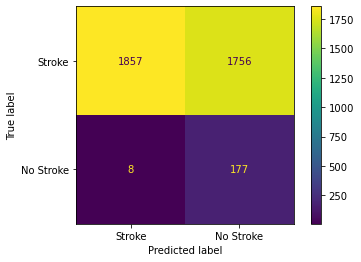

In [35]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [27]:
# Evaluate model with CV
best_xgb_results = ModelWithCV(model=best_xgb,
                         model_name='best_xgb',
                         X=X_train,
                         y=y_train)

best_xgb_results.print_cv_summary()

CV Results for `best_xgb` model:
             0.55344 accuracy
             0.90270 recall
             0.09106 precision
        


##### Round 2

In [28]:
xgb_param_grid_2 = {'sm__k_neighbors': [9, 11, 13],
                  'sm__sampling_strategy': [.8],
                  'xgb__max_depth' : [1, 2, 3],
                  'xgb__learning_rate': [.01],
                  'xgb__gamma' : [.25], #encourages pruning
                  'xgb__reg_lambda': [10, 15, 20], #regularization param
                  'xgb__scale_pos_weight': [5, 7, 9]} #penalty on choosing incorrect class

In [29]:
xgb_gs_2 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_2, 
                      cv=5,
                      scoring='recall',
                      verbose=3,
                      n_jobs=-2)

In [30]:
xgb_gs_2.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed:   25.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_

In [31]:
xgb_gs_2.best_params_

{'sm__k_neighbors': 9,
 'sm__sampling_strategy': 0.8,
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 1,
 'xgb__reg_lambda': 20,
 'xgb__scale_pos_weight': 7}

In [32]:
xgb_gs_2.best_score_

0.9837837837837838

In [33]:
best_xgb_2 = xgb_gs_2.best_estimator_

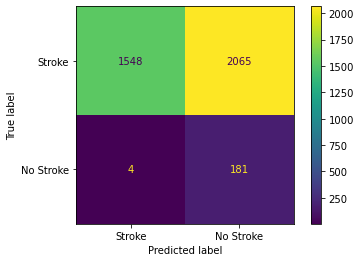

In [36]:
# Plot confusion matrix
plot_confusion_matrix(best_xgb_2, X_train, y_train, values_format='d', display_labels=['Stroke','No Stroke']);

In [34]:
# Evaluate model with CV
best_xgb_results_2 = ModelWithCV(model=best_xgb_2,
                         model_name='best_xgb_2',
                         X=X_train,
                         y=y_train)

best_xgb_results_2.print_cv_summary()

CV Results for `best_xgb_2` model:
             0.45471 accuracy
             0.95676 recall
             0.08063 precision
        


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***